In [ ]:
import os, gc
import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
from typing import List, Dict
from tqdm.notebook import tqdm

from sklearn.model_selection import KFold, GroupKFold

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
from torch.optim.lr_scheduler import OneCycleLR
from time import time, ctime

from engine_hms_trainer import (
    seed_everything, calc_entropy, evaluate_oof, get_logger, TARGETS, TARGETS_PRED, Trainer
)
from engine_hms_model import (
    KagglePaths, LocalPaths, ModelConfig
)

from scipy.signal import butter, lfilter, freqz
from scipy.stats import entropy
from scipy.special import rel_entr

pd.set_option('display.max_columns', None)

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PATHS = KagglePaths if os.path.exists(KagglePaths.OUTPUT_DIR) else LocalPaths
print("Output Dir: ", PATHS.OUTPUT_DIR)

EEG_FEAT_ALL = [
    'Fp1', 'F3', 'C3', 'P3', 
    'F7', 'T3', 'T5', 'O1', 
    'Fz', 'Cz', 'Pz', 'Fp2', 
    'F4', 'C4', 'P4', 'F8', 
    'T4', 'T6', 'O2', 'EKG'
    ]

EEG_FEAT_USE =  ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
EEF_FEAT_INDEX = {x:y for x,y in zip(EEG_FEAT_USE, range(len(EEG_FEAT_USE)))}

seed_everything(ModelConfig.SEED)

# Load Data

In [ ]:
def eeg_from_parquet(parquet_path: str, use_feature=EEG_FEAT_USE, display: bool = False) -> np.ndarray:
    # === Extract full length EEG Sequence ===
    # fill missing values with mean
    # first fill missing values with mean of each column
    # then if all values are missing, fill with 0
    eeg = pd.read_parquet(parquet_path, columns=use_feature)
    eeg = eeg.fillna(eeg.mean(skipna=True)).fillna(0)
    data = eeg.values.astype(np.float32)

    if display:
        fig, ax = plt.subplots(len(use_feature), 1, figsize=(15, 3*len(use_feature)), sharex=True)
        
        for i, feat in enumerate(use_feature):
            ax[i].plot(data[:, i], label=feat)
            ax[i].legend()
            ax[i].grid()
       
        name = parquet_path.split('/')[-1].split('.')[0]
        ax[0].set_title(f'EEG {name}',size=16)
        fig.tight_layout()
        plt.show()    
    return data

def get_non_overlap(train_csv, targets):

    df = train_csv.groupby(['eeg_id'] + targets).agg({
            'spectrogram_id': 'first',
            'spectrogram_label_offset_seconds': ['min', 'max'],
            'eeg_label_offset_seconds': ['min', 'max'],
            'patient_id': 'first',
            'expert_consensus': 'first',
            'total_votes': 'sum',
            'entropy': 'mean',
            'is_hard': 'mean'
        }).reset_index()

    df.columns = ["eeg_id"] + targets + \
        ['spectrogram_id', 'min', 'max', 'eeg_off_min', 'eeg_off_max', 'patient_id', 'target', 'total_votes', 'average_entropy', 'is_hard']

    df[targets] = df[targets].apply(lambda x: x / x.sum(), axis=1)

    return df

In [ ]:
CREATE_EEGS = False
ALL_EEG_SIGNALS = {}
eeg_paths = list(Path(PATHS.TRAIN_EEGS).glob('*.parquet'))
preload_eegs_path = Path('./inputs/eegs_full.npy')

if CREATE_EEGS:
    count = 0
    for parquet_path in tqdm(eeg_paths, total=len(eeg_paths)):
        eeg_id = int(parquet_path.stem)
        eeg_path = str(parquet_path)
        data = eeg_from_parquet(eeg_path, display=count<1)
        ALL_EEG_SIGNALS[eeg_id] = data
        count += 1
    np.save("./inputs/eegs_full.npy", ALL_EEG_SIGNALS)
else:
    ALL_EEG_SIGNALS = np.load(preload_eegs_path, allow_pickle=True).item()

In [ ]:
train_csv = pd.read_csv(PATHS.TRAIN_CSV)
targets = train_csv.columns[-6:].tolist()

print("targets: ", targets)

train_csv['total_votes'] = train_csv[targets].sum(axis=1)

targets_prob = [f"{t.split('_')[0]}_prob" for t in targets]
train_csv[targets_prob] = train_csv[targets].div(train_csv['total_votes'], axis=0)

train_csv['entropy'] = train_csv[targets_prob].apply(lambda row: sum(rel_entr([1/6]*6, row.values+1e-5)), axis=1)
train_csv['is_hard'] = (train_csv['entropy'] < 5.5).astype(int)

train_all = get_non_overlap(train_csv, targets)
train_hard = get_non_overlap(train_csv[train_csv['is_hard'] == 1].copy().reset_index(), targets)

print("train_all: ", train_all.shape)
print("hard samples: ", train_hard.shape)

train_all.head(15)

In [ ]:
ModelConfig.MODEL_BACKBONE = 'reset_gru'
ModelConfig.MODEL_NAME = "EEGSeq_Wavenet"
ModelConfig.BATCH_SIZE = 16
ModelConfig.GRADIENT_ACCUMULATION_STEPS = 1
ModelConfig.EPOCHS = 30
ModelConfig.DROP_RATE = 0.1
ModelConfig.EARLY_STOP_ROUNDS = 5

ModelConfig.RESNET_GRU_HIDDEN_SIZE = 424 # 448
ModelConfig.RESNET_GRU_INPUT_SIZE = 8
ModelConfig.RESNET_GRU_N_BLOCKS = 9
ModelConfig.RESNET_GRU_KERNELS = [3, 5, 7, 9] # [3, 5, 7, 9, 11]
ModelConfig.RESNET_GRU_FIXED_KERNEL_SIZE = 5
ModelConfig.RESNET_GRU_DROPOUT = 0.0
ModelConfig.RESNET_GRU_DOWNSAMPLE = None # None

logger = get_logger(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_train.log")

# Dataset

In [ ]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter(order, [lowcut, highcut], fs=fs, btype='band')
    y = lfilter(b, a, data)
    return y

def denoise_filter(x):
    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 200.0
    lowcut = 1.0
    highcut = 25.0
    
    # Filter a noisy signal.
    T = 50
    nsamples = T * fs
    t = np.arange(0, nsamples) / fs
    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
    y = (y + np.roll(y,-1)+ np.roll(y,-2)+ np.roll(y,-3))/4
    y = y[0:-1:4]
    
    return y

def mu_law_encoding(data, mu):
    mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
    return mu_x

def mu_law_expansion(data, mu):
    s = np.sign(data) * (np.exp(np.abs(data) * np.log(mu + 1)) - 1) / mu
    return s

def quantize_data(data, classes):
    mu_x = mu_law_encoding(data, classes)
    return mu_x #quantized

def butter_lowpass_filter(data, cutoff_freq=20, sampling_rate=200, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data


In [ ]:
class EEGSeqDataset(Dataset):
    def __init__(self, df, config, eegs, mode='train', verbose=False):
        self.df = df
        self.mode = mode
        self.eegs = eegs
        self.verbose = verbose
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        X, y_prob = self.__data_generation(idx)
        
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y_prob, dtype=torch.float32)
    
    def __data_generation(self, index):
        row = self.df.iloc[index]

        if self.verbose:
            print(f"Row {index}", row[['eeg_id', 'eeg_off_min', 'eeg_off_max', 'target']].tolist())

        X = np.zeros((10_000, 8), dtype='float32')
        
        if self.mode == 'train':
            start_sec = int((row['eeg_off_min'] + row['eeg_off_max']) // 2)
            data = self.eegs[row.eeg_id][start_sec*200 : (start_sec+50)*200]
        else:
            data = self.eegs[row.eeg_id]

        # === Feature engineering ===
        X[:,0] = data[:,EEF_FEAT_INDEX['Fp1']] - data[:,EEF_FEAT_INDEX['T3']]
        X[:,1] = data[:,EEF_FEAT_INDEX['T3']] - data[:,EEF_FEAT_INDEX['O1']]

        X[:,2] = data[:,EEF_FEAT_INDEX['Fp1']] - data[:,EEF_FEAT_INDEX['C3']]
        X[:,3] = data[:,EEF_FEAT_INDEX['C3']] - data[:,EEF_FEAT_INDEX['O1']]

        X[:,4] = data[:,EEF_FEAT_INDEX['Fp2']] - data[:,EEF_FEAT_INDEX['C4']]
        X[:,5] = data[:,EEF_FEAT_INDEX['C4']] - data[:,EEF_FEAT_INDEX['O2']]

        X[:,6] = data[:,EEF_FEAT_INDEX['Fp2']] - data[:,EEF_FEAT_INDEX['T4']]
        X[:,7] = data[:,EEF_FEAT_INDEX['T4']] - data[:,EEF_FEAT_INDEX['O2']]

        # === Standarize ===
        X = np.clip(X,-1024, 1024)
        X = np.nan_to_num(X, nan=0) / 32.0

        # === Butter Low-pass Filter ===
        # !!! change to bandpass filter (low=0.5, hight=20, order=2) !!!
        # X = butter_lowpass_filter(X)
        X = butter_bandpass_filter(X, .5, 20, 200, order=2)

        if self.mode != 'test':
            y_prob = row[TARGETS].values.astype(np.float32)
        else:
            y_prob = np.zeros(6, dtype='float32')

        return X, y_prob


In [ ]:
# visualize the dataset

# train_dataset = EEGSeqDataset(train_all, ModelConfig, ALL_EEG_SIGNALS, mode="train")
# train_loader = DataLoader(train_dataset, drop_last=True, batch_size=16, num_workers=4, pin_memory=True, shuffle=False)

# for batch in train_loader:
#     X, y = batch
#     print(f"X shape: {X.shape}")
#     print(f"y shape: {y.shape}")
    
    # fig, axes = plt.subplots(4, 1, figsize=(20, 20))
    # for item in range(4):
    #     offset = 0
    #     for col in range(X.shape[-1]):
    #         if col != 0:
    #             offset -= X[item,:,col].min()
    #         axes[item].plot(np.arange(X.shape[1]), X[item,:,col]+offset, label=f'feature {col+1}')
    #         offset += X[item,:,col].max()
    #     tt = f'{y[col][0]:0.1f}'
    #     for t in y[col][1:]:
    #         tt += f', {t:0.1f}'
    #     axes[item].set_title(f'Target = {tt}',size=14)
    #     axes[item].legend()
    # fig.tight_layout()
    # plt.show()
    # break

# Model

In [ ]:
class SeqGRUEncoder(nn.Module):
    def __init__(self, in_channels, hidden_size=128, num_layers=2, bidirectional=True):
        super(SeqGRUEncoder, self).__init__()

        self.in_channels = in_channels

        # Initialize the GRU to have 128 hidden units per direction and to be bidirectional
        self.rnn = nn.GRU(
            input_size=in_channels, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            bidirectional=bidirectional, 
            batch_first=True
        )
        
        # Initialize the attention mechanism
        if bidirectional:
            emb_dim = 2 * hidden_size
        else:
            emb_dim = hidden_size
        
        self.attention_dense = nn.Linear(emb_dim, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # x shape: [batch, seq_len, in_channels]
        rnn_out, _ = self.rnn(x)  # -> [batch, seq_len, emb_dim]
        identity = rnn_out
        scores = self.attention_dense(rnn_out).squeeze(-1)
        scores = self.softmax(scores).unsqueeze(1)
        pooled_out = torch.matmul(scores, identity).squeeze(1)
        # -> [batch_size, emb_dim]
        return pooled_out

In [ ]:
class ResNet_1D_Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, downsampling, dropout=0.0):
        super(ResNet_1D_Block, self).__init__()
        self.block = nn.Sequential(
            nn.BatchNorm1d(num_features=in_channels),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm1d(num_features=out_channels),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        )
        self.downsampling = downsampling

    def forward(self, x):
        identity = self.downsampling(x)
        out = self.block(x)
        out += identity
        return out
    
class ResNet_1D_Encoder(nn.Module):
    def __init__(self, kernels=[3,7,9,11], planes=24, in_channels=8, fixed_kernel_size=5, n_blocks=9, dropout=0.0):
        super(ResNet_1D_Encoder, self).__init__()

        self.parallel_conv = nn.ModuleList([
            nn.Conv1d(
                in_channels=in_channels, 
                out_channels=planes, 
                kernel_size=kernel_size,
                stride=1, 
                padding=0, 
                bias=False
            ) for kernel_size in kernels
        ])

        self.resnet_layer = ResNet_1D_Block(
            in_channels=planes, 
            out_channels=planes, 
            kernel_size=fixed_kernel_size,
            stride=1, 
            padding=fixed_kernel_size//2, 
            downsampling=nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
            dropout=dropout
        )
        
        self.resnet_part = nn.Sequential(
            nn.BatchNorm1d(num_features=planes),
            nn.ReLU(inplace=False),
            nn.Conv1d(
                in_channels=planes, 
                out_channels=planes, 
                kernel_size=fixed_kernel_size, 
                stride=2, 
                padding=2, 
                bias=False
            ),
            *[self.resnet_layer for _ in range(n_blocks)],
            nn.BatchNorm1d(num_features=planes),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=6, stride=6, padding=2)
        )

    def forward(self, x):
        # x shape: [batch, seq_len, in_channels]
        print("Resnet Input Shape: ", x.shape)
        x = x.permute(0, 2, 1)  # (batch, channels, seq_len)
       
        out_sep = [conv(x) for conv in self.parallel_conv]
        out = torch.cat(out_sep, dim=2)
        out = self.resnet_part(out)
        
        # Return the flattened features from the last convolutional layer
        features = out.reshape(out.shape[0], -1)
        return features


In [ ]:
from typing import List

class DilatedInception(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_sizes: List[int], dilation: int) -> None:
        super().__init__()
        assert out_channels % len(kernel_sizes) == 0, "`out_channels` must be divisible by the number of kernel sizes."
        hidden_dim = out_channels // len(kernel_sizes)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels, hidden_dim, k, padding='same', dilation=dilation)
            for k in kernel_sizes
        ])

    def forward(self, x):
        outputs = [conv(x) for conv in self.convs]
        out = torch.cat(outputs, dim=1)
        return out

class GatedTCN(nn.Module):
    def __init__(self, in_dim: int, h_dim: int, kernel_sizes: List[int], dilation_factor: int, dropout: float = 0.0) -> None:
        super().__init__()
        self.filt = DilatedInception(in_dim, h_dim, kernel_sizes, dilation=dilation_factor)
        self.gate = DilatedInception(in_dim, h_dim, kernel_sizes, dilation=dilation_factor)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x_filt = torch.tanh(self.filt(x))
        x_gate = torch.sigmoid(self.gate(x))
        h = x_filt * x_gate
        h = self.dropout(h)
        return h

class WaveBlock(nn.Module):
    def __init__(self, n_layers: int, in_dim: int, h_dim: int, kernel_sizes: List[int]) -> None:
        super().__init__()
        self.dilation_rates = [2**i for i in range(n_layers)]
        self.in_conv = nn.Conv1d(in_dim, h_dim, kernel_size=1)
        self.gated_tcns = nn.ModuleList([
            GatedTCN(h_dim, h_dim, kernel_sizes, dilation)
            for dilation in self.dilation_rates
        ])
        self.skip_convs = nn.ModuleList([
            nn.Conv1d(h_dim, h_dim, kernel_size=1)
            for _ in range(n_layers)
            ])
        self._initialize_weights()

    def _initialize_weights(self):
        nn.init.xavier_uniform_(self.in_conv.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(self.in_conv.bias)
        for conv in self.skip_convs:
            nn.init.xavier_uniform_(conv.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(conv.bias)

    def forward(self, x):
        # x: (B, C, L)
        x = self.in_conv(x)
        x_skip = x
        for gated_tcn, skip_conv in zip(self.gated_tcns, self.skip_convs):
            x = gated_tcn(x)
            x = skip_conv(x)
            x_skip = x_skip + x
        return x_skip

class DilatedWaveNet(nn.Module):
    """WaveNet architecture with dilated inception conv, enhanced with list comprehension for input processing."""

    def __init__(self, kernel_sizes: List[int]) -> None:
        super().__init__()
        self.kernel_sizes = kernel_sizes
        
        # Initialize wave blocks with specified kernel sizes
        self.wave_module = nn.Sequential(
            WaveBlock(12, 1, 16, self.kernel_sizes),
            WaveBlock(8, 16, 32, self.kernel_sizes),
            WaveBlock(4, 32, 64, self.kernel_sizes),
            WaveBlock(1, 64, 64, self.kernel_sizes),
        )
        self.pool_layer = nn.AdaptiveAvgPool1d(1)

    def forward(self, x) -> torch.Tensor:
        # x: (B, L, C)
        bs, seq_len, n_channels = x.shape
        x = x.permute(0, 2, 1) # -> (B, C, L)
        # Process different parts of the input with list comprehension
        pooled_outputs = [
            (
                self.pool_layer(self.wave_module(x[:, i:i+1])) + 
                self.pool_layer(self.wave_module(x[:, i+1:i+2]))
            ) / 2
            for i in range(0, n_channels, 2)
        ]

        # Combine the pooled features and reshape for classification
        features = torch.cat(pooled_outputs, dim=1).reshape(bs, -1)
       
        return features

In [ ]:
class EEGSeqClassifier(nn.Module):
    def __init__(self, config, num_classes=6):
        super(EEGSeqClassifier, self).__init__()

        # downsample layer (by a factor of 2)
        self.ds_layer = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=3, stride=2, padding=1)
        
        # self.seqgru = SeqGRUEncoder(in_channels=8, hidden_size=128, num_layers=2, bidirectional=True)
        # self.resnet = ResNet_1D_Encoder(
        #     kernels=[3, 7, 9, 11], 
        #     planes=24, 
        #     in_channels=8, 
        #     fixed_kernel_size=5, 
        #     n_blocks=8, 
        #     dropout=0.0
        # )
        self.wavenet = DilatedWaveNet(kernel_sizes=[2, 3, 6, 7])

        self.predict_head = nn.Linear(64*4, num_classes)

    def forward(self, x):
        # x shape: [batch, seq_len, in_channels]
        x = self.ds_layer(x.permute(0, 2, 1)) # ->(batch, channels, seq_len)
        x = x.permute(0, 2, 1)
        # resnet_out = self.resnet(x)
        # seqgru_out = self.seqgru(x)
        wavenet_out = self.wavenet(x)
        
        # features = torch.cat([seqgru_out, resnet_out, wavenet_out], dim=1)

        logits = self.predict_head(wavenet_out)
        return logits

In [ ]:
# class ResNet_1D_Block(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size, stride, padding, downsampling, dropout=0.0):
#         super(ResNet_1D_Block, self).__init__()
#         self.block = nn.Sequential(
#             nn.BatchNorm1d(num_features=in_channels),
#             nn.ReLU(),
#             nn.Dropout(p=dropout),
#             nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
#             nn.BatchNorm1d(num_features=out_channels),
#             nn.ReLU(),
#             nn.Dropout(p=dropout),
#             nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding, bias=False),
#             nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         )
#         self.downsampling = downsampling

#     def forward(self, x):
#         identity = self.downsampling(x)
#         out = self.block(x)
#         out += identity
#         return out

# class SeqPool(nn.Module):
#     def __init__(self, emb_dim):
#         super().__init__()
#         self.dense = nn.Linear(emb_dim, 1)  # Dense layer to compute attention scores
#         self.softmax = nn.Softmax(dim=-1)   # Softmax to normalize scores

#     def forward(self, x):
#         # x shape: [batch_size, seq_len, emb_dim]
#         bs, seq_len, emb_dim = x.shape
#         identity = x
#         scores = self.dense(x)
#         scores = scores.squeeze(-1).softmax(dim=-1)
#         scores = scores.unsqueeze(1)
#         pooled_output = torch.matmul(scores, identity)
#         # Final shape: [batch_size, emb_dim]
#         pooled_output = pooled_output.squeeze(1)
#         return pooled_output


# class SeqGRU(nn.Module):
#     def __init__(self, in_channels, ):
#         super(SeqGRU, self).__init__()

#         self.rnn = nn.GRU(input_size=self.in_channels, hidden_size=128, num_layers=2, bidirectional=True)
#         self.seq_pool = SeqPool(emb_dim=256)

#     def forward(self, x):

#         # x_down = self.downsample_block(x.permute(0, 2, 1))
#         rnn_out, _ = self.rnn(x)
#         new_rnn_h = self.seq_pool(rnn_out)
#         return new_rnn_h


In [ ]:
# # Define ResNetGRU model
# class ResNet_1D(nn.Module):

#     def __init__(self, config, num_classes=6):
#         super(ResNet_1D, self).__init__()

#         self.kernels = config.RESNET_GRU_KERNELS
#         self.planes = 24
#         self.in_channels = config.RESNET_GRU_INPUT_SIZE

#         # Define the separate convolutional layers
#         self.parallel_conv = nn.ModuleList([
#             nn.Conv1d(
#                 in_channels=self.in_channels, 
#                 out_channels=self.planes, 
#                 kernel_size=kernel_size,
#                 stride=1, 
#                 padding=0, 
#                 bias=False
#             ) for kernel_size in self.kernels
#         ])

#         fixed_kernel_size = config.RESNET_GRU_FIXED_KERNEL_SIZE

#         self.resnet_layer = ResNet_1D_Block(
#             in_channels=self.planes, 
#             out_channels=self.planes, 
#             kernel_size=fixed_kernel_size,
#             stride=1, 
#             padding=fixed_kernel_size//2, 
#             downsampling= nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
#             dropout=config.RESNET_GRU_DROPOUT
#             )
        
#         # Define the ResNet part of the model
#         self.resnet_part = nn.Sequential(
#             nn.BatchNorm1d(num_features=self.planes),
#             nn.ReLU(inplace=False),
#             nn.Conv1d(
#                 in_channels=self.planes, 
#                 out_channels=self.planes, 
#                 kernel_size=fixed_kernel_size, 
#                 stride=2, 
#                 padding=2, 
#                 bias=False
#             ),
#             *[self.resnet_layer for _ in range(config.RESNET_GRU_N_BLOCKS)],
#             nn.BatchNorm1d(num_features=self.planes),
#             nn.ReLU(inplace=False),
#             nn.AvgPool1d(kernel_size=6, stride=6, padding=2)
#         )

#         # Define the final fully connected layer
#         self.fc = nn.Linear(in_features=168, out_features=num_classes)

#     def forward(self, x):
#         x = x.permute(0, 2, 1) # (batch, channels, seq_len)
       
#         out_sep = [conv(x) for conv in self.parallel_conv]
#         out = torch.cat(out_sep, dim=2)
#         out = self.resnet_part(out)
#         out = out.reshape(out.shape[0], -1)

#         result = self.fc(out)
#         return result


# class ResNetGRU(nn.Module):
#     def __init__(self, config, num_classes=6):
#         super(ResNetGRU, self).__init__()

#         self.kernels = config.RESNET_GRU_KERNELS
#         self.planes = 24
#         self.in_channels = config.RESNET_GRU_INPUT_SIZE

#         # self.downsample_block = nn.Sequential(
#         #     nn.Conv1d(
#         #         in_channels=self.in_channels, 
#         #         out_channels=self.in_channels, 
#         #         kernel_size=5, 
#         #         stride=5,
#         #         dilation=2, 
#         #         padding=2, 
#         #     ),
#         #     nn.ReLU(),
#         #     nn.BatchNorm1d(num_features=self.in_channels)
#         # )

#         # # Define the separate convolutional layers
#         self.parallel_conv = self._make_parallel_conv_layers()

#         # Define the ResNet part of the model
#         self.resnet_part = self._make_resnet_part(
#             config.RESNET_GRU_FIXED_KERNEL_SIZE, config.RESNET_GRU_N_BLOCKS, config.RESNET_GRU_DROPOUT)
        
#         # Define the GRU part of the model
#         self.rnn = nn.GRU(input_size=self.in_channels, hidden_size=128, num_layers=2, bidirectional=True)
#         self.seq_pool = SeqPool(emb_dim=256)

#         # Define the final fully connected layer
#         self.fc = nn.Linear(in_features=424, out_features=num_classes)
#         # self.mlp = nn.Sequential(
#         #     nn.Linear(in_features=config.RESNET_GRU_HIDDEN_SIZE, out_features=256),
#         #     nn.ReLU(inplace=True),
#         #     nn.Dropout(p=config.DROP_RATE),
#         #     nn.Linear(in_features=256, out_features=num_classes)
#         # )

#     def _make_parallel_conv_layers(self):
#         return nn.ModuleList([
#             nn.Conv1d(
#                 in_channels=self.in_channels, 
#                 out_channels=self.planes, 
#                 kernel_size=kernel_size,
#                 stride=1, 
#                 padding=0, 
#                 bias=False
#             ) for kernel_size in self.kernels
#         ])

#     def _make_resnet_part(self, fixed_kernel_size, blocks=9, dropout=0.0):
#         # prepare resnet layers
#         downsampling = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         resnet_layers = [
#             ResNet_1D_Block(
#                 in_channels=self.planes, 
#                 out_channels=self.planes, 
#                 kernel_size=fixed_kernel_size, 
#                 stride=1, 
#                 padding=fixed_kernel_size//2, 
#                 downsampling=downsampling,
#                 dropout=dropout)
#             for _ in range(blocks)
#         ]
#         # return the resnet encoder
#         return nn.Sequential(
#             nn.BatchNorm1d(num_features=self.planes),
#             nn.ReLU(inplace=False),
#             nn.Conv1d(
#                 in_channels=self.planes, 
#                 out_channels=self.planes, 
#                 kernel_size=fixed_kernel_size, 
#                 stride=2, 
#                 padding=2, 
#                 bias=False
#             ),
#             *resnet_layers,
#             nn.BatchNorm1d(num_features=self.planes),
#             nn.ReLU(inplace=False),
#             nn.AvgPool1d(kernel_size=6, stride=6, padding=2)
#         )
    
#     def forward(self, x):
        
#         x = x.permute(0, 2, 1) # (batch, channels, seq_len)
#         # x_down = self.downsample_block(x)

#         # extract features using resnet 
#         out_sep = [conv(x) for conv in self.parallel_conv]
#         out = torch.cat(out_sep, dim=2)
#         out = self.resnet_part(out)
#         out = out.reshape(out.shape[0], -1)
        
#         # extract features using rnn
#         rnn_out, _ = self.rnn(x.permute(0, 2, 1))
#         new_rnn_h = x = self.seq_pool(rnn_out)

#         # # concatenate the features
#         new_out = torch.cat([out, new_rnn_h], dim=1) 

#         # pass through the final fully connected layer
#         # result = self.mlp(new_out)
#         result = self.fc(new_out)  
        
#         return result

In [ ]:
train_dataset = EEGSeqDataset(train_all, ModelConfig, ALL_EEG_SIGNALS, mode="train")
train_loader = DataLoader(train_dataset, drop_last=True, batch_size=16, num_workers=4, pin_memory=True, shuffle=False)

# model = SeqGRU( in_channels=8, hidden_size=128, num_layers=2, bidirectional=True)
# model = ResNet_1D_Encoder(in_channels=8)
model = EEGSeqClassifier(ModelConfig, num_classes=6)
model.to(DEVICE)
for i, batch in enumerate(train_loader):
    X, y = batch
    X = X.to(DEVICE)
    y = y.to(DEVICE)
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    
    y_pred = model(X)
    print(y_pred.shape)
    break 

In [ ]:
# del model, train_dataset, train_loader
torch.cuda.empty_cache()
gc.collect()

In [ ]:
!nvidia-smi

In [ ]:
# feature_id = 0
# feat = rnn_out.detach().cpu().numpy()
# print(feat[0].mean(axis=0).shape)

# fig, ax = plt.subplots(2, 1, figsize=(20, 5))
# # for i in range(0, feat.shape[1], 16):
# #     ax[0].plot(feat[:, i].detach().cpu().numpy())
# ax[0].plot(feat[0, -1, :])
# ax[0].plot(feat[0].mean(axis=0))
# ax[1].plot(resnet_out[0].detach().cpu().numpy())

# plt.title(f"Feature {feature_id}")
# plt.show()

# Train

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def prepare_k_fold(df, k_folds=5):

    kf = KFold(n_splits=k_folds)
    unique_spec_id = df['spectrogram_id'].unique()
    df['fold'] = k_folds

    for fold, (train_index, valid_index) in enumerate(kf.split(unique_spec_id)):
        df.loc[df['spectrogram_id'].isin(unique_spec_id[valid_index]), 'fold'] = fold

    return df


def train_fold(model, fold_id, train_folds, valid_folds, logger, stage=1, checkpoint=None):

    train_dataset = EEGSeqDataset(train_folds, ModelConfig, ALL_EEG_SIGNALS, mode="train")
    valid_dataset = EEGSeqDataset(valid_folds, ModelConfig, ALL_EEG_SIGNALS, mode="valid")

    # ======== DATALOADERS ==========
    loader_kwargs = {
        "batch_size": ModelConfig.BATCH_SIZE,
        "num_workers": ModelConfig.NUM_WORKERS,
        "pin_memory": True,
        "shuffle": False,
    }

    train_loader = DataLoader(train_dataset, drop_last=True, collate_fn=None, **loader_kwargs)
    valid_loader = DataLoader(valid_dataset, drop_last=False, collate_fn=None, **loader_kwargs)

    trainer = Trainer(model, ModelConfig, logger)
    best_weights, best_preds, loss_records = trainer.train(
        train_loader, valid_loader, from_checkpoint=checkpoint)

    save_model_name = f"{ModelConfig.MODEL_NAME}_fold_{fold_id}_stage_{stage}.pth"
    torch.save(best_weights, os.path.join(PATHS.OUTPUT_DIR, save_model_name))

    del train_dataset, valid_dataset, train_loader, valid_loader
    torch.cuda.empty_cache()
    gc.collect()

    return best_preds, loss_records

In [ ]:
k_folds = 5
train_all = prepare_k_fold(train_all, k_folds=k_folds)

# gkf = GroupKFold(n_splits=k_folds)
# for fold, (train_index, valid_index) in enumerate(gkf.split(train_all, train_all.target, train_all.patient_id)):
#     train_all.loc[valid_index, "fold"] = int(fold)

# for fold in range(k_folds):
#     print(f"Fold {fold} = {len(train_all[train_all['fold'] == fold])}")

In [ ]:
# Major Train Loop
# ================== Logger ==================
logger.info(f"{'*' * 100}")
logger.info(f"Script Start: {ctime()}")
logger.info(f"Model Configurations:")
for key, value in ModelConfig.__dict__.items():
    if not key.startswith("__"):
        logger.info(f"{key}: {value}")
logger.info(f"{'*' * 100}")

# ================== Run Training ==================
oof_stage_1 = pd.DataFrame()
loss_history_1 = []

logger.info(f"{'=' * 100}\nStage 1: Train ResNetGRU\n{'=' * 100}")
for fold in range(k_folds):
    tik = time()

    ModelConfig.RESNET_GRU_DROPOUT = 0.0

    # model = ResNetGRU( ModelConfig, num_classes=6 )
    model = EEGSeqClassifier(ModelConfig, num_classes=6)
    
    valid_folds = train_all[train_all['fold'] == fold].reset_index(drop=True)
    train_folds = train_all[train_all['fold'] != fold].reset_index(drop=True)

    ## STAGE 1
    logger.info(f"{'=' * 100}\nFold: {fold} || Valid: {valid_folds.shape[0]}; \n{'=' * 100}")
    logger.info(f"- Train: {train_folds.shape[0]}; Epoch = {ModelConfig.EPOCHS}; Dropout = {ModelConfig.RESNET_GRU_DROPOUT} -")
    valid_predicts, loss_records = train_fold(
        model, fold, train_folds, valid_folds, logger, stage=1, checkpoint=None)

    loss_history_1.append(loss_records)
    valid_folds[TARGETS_PRED] = valid_predicts
    oof_stage_1 = pd.concat([oof_stage_1, valid_folds], axis=0).reset_index(drop=True)
    kl_loss_torch = evaluate_oof(valid_folds)
    info = f"{'=' * 100}\nFold {fold} Valid Loss: {kl_loss_torch}\n"
    info += f"Elapse: {(time() - tik) / 60:.2f} min \n{'=' * 100}"
    logger.info(info)
    oof_stage_1.to_csv(os.path.join(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_oof_1.csv"), index=False)

In [ ]:
# plot loss history
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i, loss in enumerate(loss_history_1):
    ax.plot(loss['train'], marker="*", ls="-", label=f"Fold {i} Train")
    ax.plot(loss['valid'], marker="o", ls=":", label=f"Fold {i} Valid")

ax.grid()
fig.tight_layout()
plt.legend()
plt.show()

In [ ]:
train_hard

In [ ]:
## STAGE 2
oof_stage_2 = pd.DataFrame()
loss_history_2 = []

k_folds = 5
train_all = prepare_k_fold(train_hard, k_folds=k_folds)

logger.info(f"{'=' * 100}\nStage 2: Train ResNetGRU\n{'=' * 100}")
for fold in range(k_folds):
    tik = time()
    
    ModelConfig.EPOCHS = 10
    ModelConfig.RESNET_GRU_DROPOUT = 0.0

    train_folds = train_hard[train_hard['fold'] != fold].reset_index(drop=True)
    valid_folds = train_hard[train_hard['fold'] == fold].reset_index(drop=True)

    logger.info(f"- Hard: {train_folds.shape[0]}; Epoch: {ModelConfig.EPOCHS}; Dropout: {ModelConfig.RESNET_GRU_DROPOUT} -")
    check_point = os.path.join(
        PATHS.OUTPUT_DIR,
        f"{ModelConfig.MODEL_NAME}_fold_{fold}_stage_1.pth"
    )
    logger.info(f"Use Checkpoint: {check_point.split('/')[-1]}")

    model = ResNetGRU(ModelConfig, num_classes=6)

    valid_predicts, loss_records = train_fold(
        model, fold, train_folds, valid_folds, logger, stage=2, checkpoint=check_point)

    loss_history_2.append(loss_records)
    valid_folds[TARGETS_PRED] = valid_predicts
    oof_stage_2 = pd.concat([oof_stage_2, valid_folds], axis=0).reset_index(drop=True)
    kl_loss_torch = evaluate_oof(valid_folds)
    info = f"{'=' * 100}\nFold {fold} Valid Loss: {kl_loss_torch}\n"
    info += f"Elapse: {(time() - tik) / 60:.2f} min \n{'=' * 100}"
    logger.info(info)
    oof_stage_2.to_csv(os.path.join(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_oof_2.csv"), index=False)

In [ ]:
# plot loss history
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i, loss in enumerate(loss_history_2):
    ax.plot(loss['train'], marker="*", ls="-", label=f"Fold {i} Train")
    ax.plot(loss['valid'], marker="o", ls=":", label=f"Fold {i} Valid")

ax.grid()
fig.tight_layout()
plt.legend()
plt.show()

In [ ]:
from kl_divergence import score as kaggle_score 
from sklearn.metrics import confusion_matrix
import seaborn as sns

TARGET2ID = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other': 5}

def calc_kaggle_score(oof_df):
    submission_df = oof_df[['eeg_id']+TARGETS_PRED].copy()
    submission_df.columns = ['eeg_id'] + TARGETS
    solution_df = oof_df[['eeg_id']+TARGETS].copy()
    return kaggle_score(solution_df, submission_df, 'eeg_id')

def analyze_oof(oof_csv):

    kl_criteria = nn.KLDivLoss(reduction='batchmean')
    softmax = nn.Softmax(dim=1)

    oof_df = pd.read_csv(oof_csv)
    oof_df['target_pred'] = oof_df[TARGETS_PRED].apply(lambda x: np.argmax(x), axis=1)
    oof_df['target_id'] = oof_df[TARGETS].apply(lambda x: np.argmax(x), axis=1)
    
    oof_df["kl_loss"] = oof_df.apply(
    lambda row: 
        kl_criteria(
            F.log_softmax(
                    torch.tensor(row[TARGETS_PRED].values.astype(np.float32)).unsqueeze(0)
                , dim=1
                ), 
            torch.tensor(row[TARGETS].values.astype(np.float32))
            ).numpy(),
    axis=1)

    oof_df["kl_loss"] = oof_df['kl_loss'].astype(np.float32)

    oof_df[TARGETS_PRED] = softmax( torch.tensor(oof_df[TARGETS_PRED].values.astype(np.float32)) )

    oof_df.head()

    return oof_df

In [ ]:
csv_path = f'./outputs/{ModelConfig.MODEL_NAME}_oof_2.csv'
print("CSV Path: ", csv_path)

oof_df = analyze_oof(csv_path)

print("Kaggle Score: ", calc_kaggle_score(oof_df))
print("Average KL Loss: ", oof_df["kl_loss"].mean())

display(oof_df.head())

# plot confusion matrix
cm = confusion_matrix(oof_df['target_id'], oof_df['target_pred']) # (y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys())
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(csv_path.split('/')[-1].split('.')[0], fontsize=12)
fig.tight_layout()
fig.savefig(f"./outputs/{csv_path.split('/')[-1].split('.')[0]}_CM.png")
plt.show()

CSV Path:  ./outputs/EEGSeq_DilatedResNet_Deep_oof_2.csv
Kaggle Score:  0.8354729513547227
Average KL Loss:  0.83547294


,eeg_id,spectrogram_id,min,max,eeg_off_min,eeg_off_max,eeg_off_sample,patient_id,target,total_votes,entropy,is_hard,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,is_stage,fold,seizure_pred,lpd_pred,gpd_pred,lrda_pred,grda_pred,other_pred,target_pred,target_id,kl_loss
0,568657,789577333,0.0,16.0,0.0,16.0,0.0,20654,Other,48,4.584192,1.0,0.000000,0.000000,0.25,0.000000,0.166667,0.583333,2,0,0.275016,0.050645,0.076782,0.066604,0.076070,0.454882,5,5,0.570933
1,582999,1552638400,0.0,38.0,0.0,38.0,22.0,20230,LPD,154,4.870032,1.0,0.000000,0.857143,0.00,0.071429,0.000000,0.071429,2,0,0.315447,0.034278,0.000995,0.141722,0.007103,0.500455,5,1,2.571229
2,1629671,2036345030,0.0,160.0,0.0,160.0,126.0,37481,Seizure,51,7.802343,0.0,1.000000,0.000000,0.00,0.000000,0.000000,0.000000,2,0,0.792870,0.040527,0.001824,0.103816,0.006020,0.054943,0,0,0.232095
3,1895581,128369999,1138.0,1138.0,0.0,0.0,0.0,47999,Other,13,4.847483,1.0,0.076923,0.000000,0.00,0.000000,0.076923,0.846154,2,0,0.693013,0.010782,0.001226,0.037620,0.005504,0.251855,0,5,1.059192
4,2366870,1232582129,0.0,30.0,0.0,30.0,0.0,23633,Other,18,6.134196,0.0,0.000000,0.333333,0.00,0.000000,0.000000,0.666667,2,0,0.024653,0.005294,0.000579,0.018036,0.000542,0.950897,5,5,1.144134


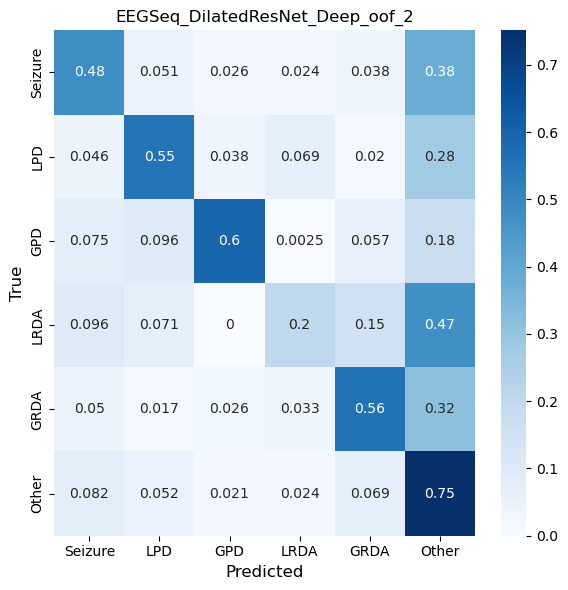

In [27]:
csv_path = f'./outputs/EEGSeq_DilatedResNet_Deep_oof_2.csv'
print("CSV Path: ", csv_path)

oof_df = analyze_oof(csv_path)

print("Kaggle Score: ", calc_kaggle_score(oof_df))
print("Average KL Loss: ", oof_df["kl_loss"].mean())

display(oof_df.head())

# plot confusion matrix
cm = confusion_matrix(oof_df['target_id'], oof_df['target_pred']) # (y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys())
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(csv_path.split('/')[-1].split('.')[0], fontsize=12)
fig.tight_layout()
fig.savefig(f"./outputs/{csv_path.split('/')[-1].split('.')[0]}_CM.png")
plt.show()

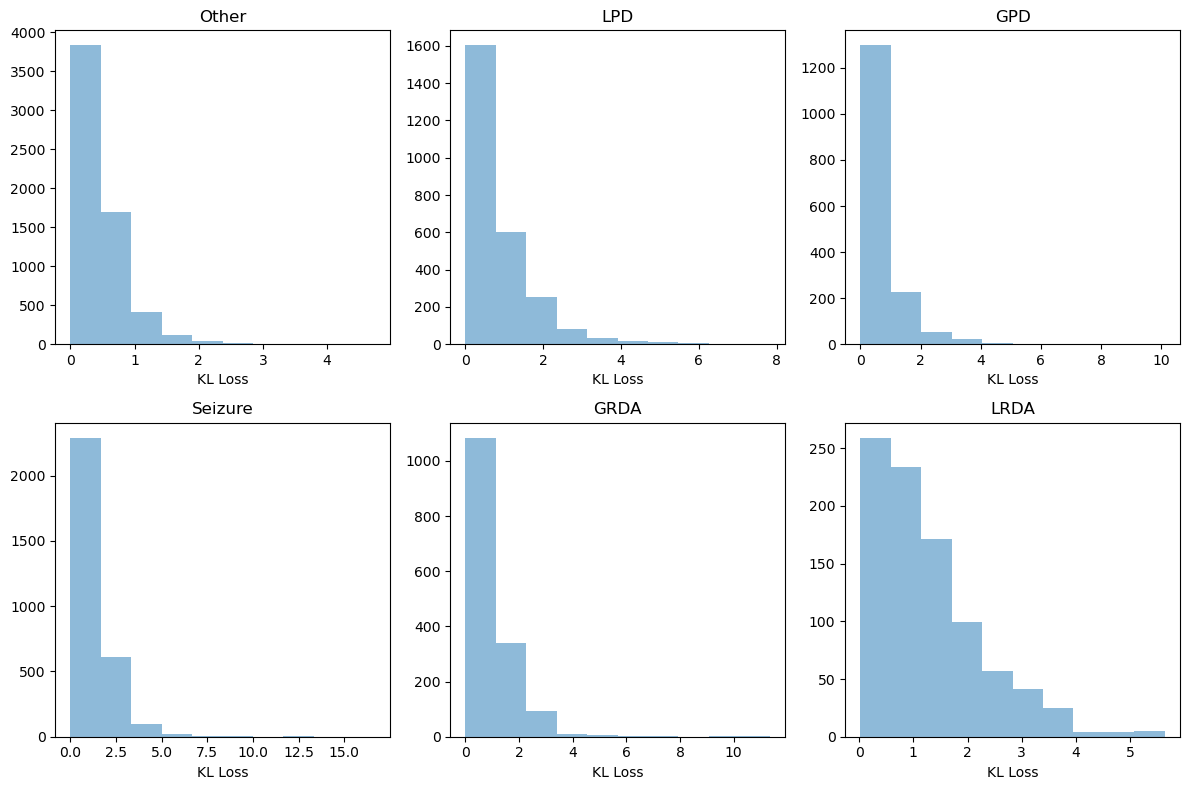

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for ax, tgt in zip(axes.flatten(), oof_df['target'].unique()):
    ax.hist(oof_df[oof_df['target'] == tgt]['kl_loss'], bins=10, alpha=0.5, label='kl_loss')
    ax.set_title(f"{tgt}")
    ax.set_xlabel('KL Loss')
fig.tight_layout()
plt.show()